In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import mysql.connector

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')
cur = con.cursor()

Q: How are tmdb ratings linked to revenue and profitability? (simplified)

In [39]:
#simplified
query1="""select title, popularity, vote_average, vote_count 
production_budget, domestic_gross, worldwide_gross
from tmdb_movies join tn_movie_budgets on title=movie"""
#cur.execute(query,con)
#df=pd.DataFrame(cur.fetchall())
#df.columns = [x[0] for x in cur.description()]
#df
df1 = pd.read_sql_query(query1, con)
df1.head()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2448 non-null   object 
 1   popularity         2448 non-null   float64
 2   vote_average       2448 non-null   float64
 3   production_budget  2448 non-null   int64  
 4   domestic_gross     2448 non-null   object 
 5   worldwide_gross    2448 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 114.9+ KB


In [8]:
df1[df1.columns[3:]] = df1[df1.columns[3:]].replace('[\$,]', '', regex=True).astype(float)

In [9]:
df1['profitability'] = df1['worldwide_gross']-df1['production_budget']

In [10]:
df1.sort_values(by=['profitability'],ascending=False)

,title,popularity,vote_average,production_budget,domestic_gross,worldwide_gross,profitability
5,Avatar,26.526,7.4,18676.0,760507625.0,2.776345e+09,2.776327e+09
2240,Avengers: Infinity War,80.773,8.3,13948.0,678815482.0,2.048134e+09,2.048120e+09
1430,Jurassic World,20.709,6.6,14056.0,652270625.0,1.648855e+09,1.648841e+09
1433,Furious 7,20.396,7.3,6538.0,353007020.0,1.518723e+09,1.518716e+09
581,The Avengers,50.289,7.6,19673.0,623279547.0,1.517936e+09,1.517916e+09
...,...,...,...,...,...,...,...
1810,Hush,12.194,6.8,2147.0,0.0,0.000000e+00,-2.147000e+03
1487,Home,12.835,6.8,2372.0,0.0,0.000000e+00,-2.372000e+03
2071,Bright,15.677,6.2,3181.0,0.0,0.000000e+00,-3.181000e+03
2281,Bird Box,26.156,7.0,4777.0,0.0,0.000000e+00,-4.777000e+03


Text(0, 0.5, 'profitability')

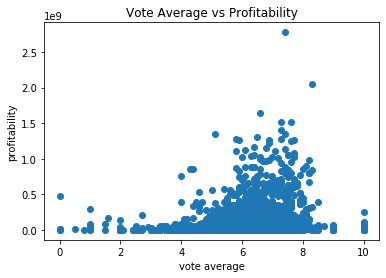

In [15]:
plt.scatter(df1['vote_average'],df1['profitability'])
plt.title('Vote Average vs Profitability')
plt.xlabel('vote average')
plt.ylabel('profitability')

Q2: Is there a better way to incorporate both tables of revenue to see a better trend?
TMDB has the most cells - left joining here should allow for full representation of both revenue tables. This did not end up being the case, as evidenced by the length

In [25]:
join_tmdb_rev_tables_query = """SELECT DISTINCT
    t.id as tmdb_id,
    t.title,
    year,
    popularity,
    vote_average,
    vote_count production_budget,
    tn.domestic_gross as tn_domestic_gross,
    tn.worldwide_gross as tn_worldwide_gross,
    b.domestic_gross as bom_domestic_gross,
    b.foreign_gross as bom_foreign_gross
FROM
    tmdb_movies t
        LEFT JOIN
    tn_movie_budgets tn ON title = movie
        LEFT JOIN
    bom_movie_gross b USING (title)
WHERE
    (tn.domestic_gross IS NOT NULL
        OR tn.worldwide_gross IS NOT NULL
        OR b.domestic_gross IS NOT NULL
        OR b.foreign_gross IS NOT NULL)
"""
df_tmdb_rev =  pd.read_sql_query(join_tmdb_rev_tables_query, con)
df_tmdb_rev[df_tmdb_rev.columns[6:8]] = df_tmdb_rev[df_tmdb_rev.columns[6:8]].replace('[\$,]', '', regex=True).astype(float)

In [26]:
df_tmdb_rev.head()

,tmdb_id,title,year,popularity,vote_average,production_budget,tn_domestic_gross,tn_worldwide_gross,bom_domestic_gross,bom_foreign_gross
0,10193,Toy Story 3,2010.0,24.445,7.7,8340,415004880.0,1.068880e+09,415000000.0,652000000.0
1,27205,Inception,2010.0,27.920,8.3,22186,292576195.0,8.355246e+08,292600000.0,535700000.0
2,10192,Shrek Forever After,2010.0,15.041,6.1,3843,238736787.0,7.562447e+08,238700000.0,513900000.0
3,24021,The Twilight Saga: Eclipse,2010.0,20.340,6.0,4909,300531751.0,7.061028e+08,300500000.0,398000000.0
4,10138,Iron Man 2,2010.0,28.515,6.8,12368,312433331.0,6.211564e+08,312400000.0,311500000.0


In [7]:
df_tmdb_rev.to_csv('tmdb_combined_movie_revenue')

In [8]:
df_tmdb_rev.shape

(3498, 10)

Q3: how can i outer join the revenue tables to have a full picture of revenue

In [11]:
query2 = """SELECT 
    CASE
        WHEN title IS NULL THEN movie
        ELSE title
    END AS movie_title,
    release_date,
    year,
    production_budget,
    CASE
        WHEN title IS NULL THEN tmdb_domestic_gross
        ELSE bom_domestic_gross
    END AS domestic_gross,
    CASE
        WHEN title IS NULL THEN tmdb_worldwide_gross
        ELSE bom_domestic_gross + bom_foreign_gross
    END AS worldwide_gross
FROM
    (SELECT DISTINCT
        title,
            movie,
            CASE
                WHEN b.domestic_gross IS NULL THEN 0
                ELSE b.domestic_gross
            END AS bom_domestic_gross,
            CASE
                WHEN b.foreign_gross IS NULL THEN 0
                ELSE b.foreign_gross
            END AS bom_foreign_gross,
            release_date,
            year,
            production_budget,
            t.domestic_gross AS tmdb_domestic_gross,
            t.worldwide_gross AS tmdb_worldwide_gross
    FROM
        bom_movie_gross b
    LEFT JOIN tn_movie_budgets t ON movie = title
    WHERE
        b.domestic_gross IS NOT NULL
            OR b.foreign_gross IS NOT NULL
            OR t.domestic_gross IS NOT NULL
            OR t.worldwide_gross IS NOT NULL UNION SELECT DISTINCT
        title,
            movie,
            CASE
                WHEN b.domestic_gross IS NULL THEN 0
                ELSE b.domestic_gross
            END AS bom_domestic_gross,
            CASE
                WHEN b.foreign_gross IS NULL THEN 0
                ELSE b.foreign_gross
            END AS bom_foreign_gross,
            release_date,
            year,
            production_budget,
            t.domestic_gross AS tmdb_domestic_gross,
            t.worldwide_gross AS tmdb_worldwide_gross
    FROM
        bom_movie_gross b
    RIGHT JOIN tn_movie_budgets t ON movie = title
    WHERE
        b.domestic_gross IS NOT NULL
            OR b.foreign_gross IS NOT NULL
            OR t.domestic_gross IS NOT NULL
            OR t.worldwide_gross IS NOT NULL
    ORDER BY bom_domestic_gross) a
"""
df_joint_rev =  pd.read_sql_query(query2, con)

In [12]:
df_joint_rev.head()

,movie_title,release_date,year,production_budget,domestic_gross,worldwide_gross
0,Bucky and the Squirrels,"Dec 31, 2013",NaN,"$500,000",$0,$0
1,Touching the Void,"Jan 23, 2004",NaN,"$2,000,000","$4,593,598","$15,396,525"
2,River's Edge,"May 8, 1987",NaN,"$1,900,000","$4,600,000","$4,600,000"
3,The Proposition,"May 5, 2006",NaN,"$20,000,000","$1,903,434","$5,313,608"
4,A.C.O.R.N.S.: Operation Crackdown,"Nov 1, 2016",NaN,"$8,500,000",$0,"$1,353,287"


In [40]:
df_joint_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7891 entries, 0 to 7890
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_title        7891 non-null   object 
 1   release_date       5782 non-null   object 
 2   year               3396 non-null   float64
 3   production_budget  5782 non-null   object 
 4   domestic_gross     7891 non-null   object 
 5   worldwide_gross    7891 non-null   object 
dtypes: float64(1), object(5)
memory usage: 370.0+ KB


In [16]:
df_joint_rev[df_joint_rev.columns[3:]] = df_joint_rev[df_joint_rev.columns[3:]].replace('[\$,]', '', regex=True).astype(float)

df_joint_rev.head()

,movie_title,release_date,year,production_budget,domestic_gross,worldwide_gross
0,Bucky and the Squirrels,"Dec 31, 2013",NaN,500000.0,0.0,0.0
1,Touching the Void,"Jan 23, 2004",NaN,2000000.0,4593598.0,15396525.0
2,River's Edge,"May 8, 1987",NaN,1900000.0,4600000.0,4600000.0
3,The Proposition,"May 5, 2006",NaN,20000000.0,1903434.0,5313608.0
4,A.C.O.R.N.S.: Operation Crackdown,"Nov 1, 2016",NaN,8500000.0,0.0,1353287.0


In [42]:
df_joint_rev.to_csv('joined_revenue')

In [8]:
df_joint_rev=pd.read_csv('joined_revenue')

In [4]:
df_joint_rev.head()

,Unnamed: 0,movie_title,release_date,year,production_budget,domestic_gross,worldwide_gross
0,0,Friday the 13th Part 2,"Apr 30, 1981",NaN,1250000.0,21722776.0,21722776.0
1,1,Punch-Drunk Love,"Oct 11, 2002",NaN,25000000.0,17791031.0,24591031.0
2,2,Catch-22,"Jun 24, 1970",NaN,18000000.0,24911670.0,24911670.0
3,3,Stardust,"Aug 10, 2007",NaN,70000000.0,38634938.0,137022245.0
4,4,Notting Hill,"May 28, 1999",NaN,42000000.0,116089678.0,363728085.0


In [6]:
df_joint_rev = df_joint_rev.drop(['Unnamed: 0'], axis=1)

In [17]:
df_joint_rev.head()

,movie_title,release_date,year,production_budget,domestic_gross,worldwide_gross
0,Bucky and the Squirrels,"Dec 31, 2013",NaN,500000.0,0.0,0.0
1,Touching the Void,"Jan 23, 2004",NaN,2000000.0,4593598.0,15396525.0
2,River's Edge,"May 8, 1987",NaN,1900000.0,4600000.0,4600000.0
3,The Proposition,"May 5, 2006",NaN,20000000.0,1903434.0,5313608.0
4,A.C.O.R.N.S.: Operation Crackdown,"Nov 1, 2016",NaN,8500000.0,0.0,1353287.0


Q4. can i combine year release for use in future joins?

In [15]:
df_joint_rev = df_joint_rev.drop(['Unnamed: 0'], axis=1)

In [17]:
df_joint_rev['release_date_year'] = pd.DatetimeIndex(df_joint_rev['release_date']).year

In [18]:
df_joint_rev.head()

,movie_title,release_date,year,production_budget,domestic_gross,worldwide_gross,release_date_year
0,Friday the 13th Part 2,"Apr 30, 1981",NaN,1250000.0,21722776.0,21722776.0,1981.0
1,Punch-Drunk Love,"Oct 11, 2002",NaN,25000000.0,17791031.0,24591031.0,2002.0
2,Catch-22,"Jun 24, 1970",NaN,18000000.0,24911670.0,24911670.0,1970.0
3,Stardust,"Aug 10, 2007",NaN,70000000.0,38634938.0,137022245.0,2007.0
4,Notting Hill,"May 28, 1999",NaN,42000000.0,116089678.0,363728085.0,1999.0


In [19]:
df_joint_rev = df_joint_rev.drop(['release_date'], axis=1)

In [58]:
df_joint_rev1 = df_joint_rev.dropna(axis=0,subset = ['year','release_date_year'])
#confirming year matches
df_joint_rev1.head()

,movie_title,year,production_budget,domestic_gross,worldwide_gross,release_date_year,test,release_year
3775,It's a Wonderful Afterlife,2010.0,10000000.0,0.0,1300000.0,2010.0,2010.0,2010.0
4175,All the Boys Love Mandy Lane,2013.0,750000.0,0.0,1900000.0,2013.0,2013.0,2013.0
4540,Jackpot,2014.0,400000.0,800.0,1100800.0,2001.0,2014.0,2014.0
4546,Khumba,2013.0,15000000.0,1000.0,27201000.0,2013.0,2013.0,2013.0
4548,Skin Trade,2015.0,9000000.0,1200.0,1200.0,2015.0,2015.0,2015.0


In [59]:
df_joint_rev1.drop(df_joint_rev1[df_joint_rev1['year'] == df_joint_rev1['release_year']].index, inplace = True)

/Users/kcahlers/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [60]:
df_joint_rev1.head()
#no years remain where year != release year

,movie_title,year,production_budget,domestic_gross,worldwide_gross,release_date_year,test,release_year


In [33]:
df_joint_rev = df_joint_rev.assign(release_year=np.where(df_joint_rev.year.isnull(),df_joint_rev.release_date_year , df_joint_rev.year))

In [61]:
df_joint_rev.head()

,movie_title,year,production_budget,domestic_gross,worldwide_gross,release_date_year,test,release_year
0,Friday the 13th Part 2,NaN,1250000.0,21722776.0,21722776.0,1981.0,1981.0,1981.0
1,Punch-Drunk Love,NaN,25000000.0,17791031.0,24591031.0,2002.0,2002.0,2002.0
2,Catch-22,NaN,18000000.0,24911670.0,24911670.0,1970.0,1970.0,1970.0
3,Stardust,NaN,70000000.0,38634938.0,137022245.0,2007.0,2007.0,2007.0
4,Notting Hill,NaN,42000000.0,116089678.0,363728085.0,1999.0,1999.0,1999.0


In [62]:
df_joint_rev = df_joint_rev.drop(['year'], axis=1)
df_joint_rev = df_joint_rev.drop(['release_date_year'], axis=1)
df_joint_rev = df_joint_rev.drop(['test'], axis=1)
df_joint_rev.head()

,movie_title,production_budget,domestic_gross,worldwide_gross,release_year
0,Friday the 13th Part 2,1250000.0,21722776.0,21722776.0,1981.0
1,Punch-Drunk Love,25000000.0,17791031.0,24591031.0,2002.0
2,Catch-22,18000000.0,24911670.0,24911670.0,1970.0
3,Stardust,70000000.0,38634938.0,137022245.0,2007.0
4,Notting Hill,42000000.0,116089678.0,363728085.0,1999.0


In [68]:
df_joint_rev.to_csv('joined_revenue')

Q5. who are the best actors/drirectors etc by revenue

In [5]:
query_names="""SELECT DISTINCT
    n.nconst,
    primary_name,
    primary_profession,
    primary_title,
    start_year
FROM
    imdb_title_principals p
        JOIN
    imdb_title_basics t USING (tconst)
        JOIN
    imdb_name_basics n USING (nconst)"""
df_names = pd.read_sql_query(query_names,con)
df_names.head()


,nconst,primary_name,primary_profession,primary_title,start_year
0,nm0000002,Lauren Bacall,"actress,soundtrack",Cameraman: The Life and Work of Jack Cardiff,2010
1,nm0000002,Lauren Bacall,"actress,soundtrack",Diana Vreeland: The Eye Has to Travel,2011
2,nm0000002,Lauren Bacall,"actress,soundtrack",The Forger,2012
3,nm0000002,Lauren Bacall,"actress,soundtrack",Wide Blue Yonder,2010
4,nm0000003,Brigitte Bardot,"actress,soundtrack,producer",1960,2010


In [67]:
df_names.shape

(1027204, 5)

In [6]:
df_names.to_csv('names_movies')

In [8]:
df_names=pd.read_csv('names_movies')
df_names.head()
df_joint_rev = pd.read_csv('joined_revenue')

In [10]:
df_names_rev = df_names.merge(df_joint_rev, how='inner', left_on =['primary_title','start_year'], right_on=['movie_title','release_year'])

In [13]:
df_names_rev.shape

(22784, 12)

In [14]:
df_names_rev.to_csv('df_names_rev')

In [3]:
df_names_rev = pd.read_csv('df_names_rev')

In [4]:
df_names_rev.head()

,Unnamed: 0,Unnamed: 0_x,nconst,primary_name,primary_profession,primary_title,start_year,Unnamed: 0_y,movie_title,production_budget,domestic_gross,worldwide_gross,release_year
0,0,13,nm0000006,Ingrid Bergman,"actress,soundtrack,producer",Ingrid Bergman: In Her Own Words,2015,5412,Ingrid Bergman: In Her Own Words,NaN,138000.0,138000.0,2015.0
1,1,17688,nm0006219,Michael Nyman,"composer,music_department,soundtrack",Ingrid Bergman: In Her Own Words,2015,5412,Ingrid Bergman: In Her Own Words,NaN,138000.0,138000.0,2015.0
2,2,37268,nm0084983,Stig Björkman,"director,writer,miscellaneous",Ingrid Bergman: In Her Own Words,2015,5412,Ingrid Bergman: In Her Own Words,NaN,138000.0,138000.0,2015.0
3,3,60056,nm0197061,Eva Dahlgren,"soundtrack,actress,composer",Ingrid Bergman: In Her Own Words,2015,5412,Ingrid Bergman: In Her Own Words,NaN,138000.0,138000.0,2015.0
4,4,60948,nm0202220,Dominika Daubenbüchel,"editor,writer",Ingrid Bergman: In Her Own Words,2015,5412,Ingrid Bergman: In Her Own Words,NaN,138000.0,138000.0,2015.0


In [8]:
df_names_rev_skinny = df_names_rev.drop(['Unnamed: 0', 'Unnamed: 0_x', 'primary_title','start_year','Unnamed: 0_y','movie_title','production_budget','domestic_gross','release_year'], axis=1)
v.head()

,nconst,primary_name,primary_profession,worldwide_gross
0,nm0000006,Ingrid Bergman,"actress,soundtrack,producer",138000.0
1,nm0006219,Michael Nyman,"composer,music_department,soundtrack",138000.0
2,nm0084983,Stig Björkman,"director,writer,miscellaneous",138000.0
3,nm0197061,Eva Dahlgren,"soundtrack,actress,composer",138000.0
4,nm0202220,Dominika Daubenbüchel,"editor,writer",138000.0


In [13]:
df_names_rev_grouped = df_names_rev_skinny.groupby(['nconst','primary_name', 'primary_profession']).sum().sort_values(by=['worldwide_gross'], ascending = False)

In [14]:
df_names_rev_grouped

,,,worldwide_gross
nconst,primary_name,primary_profession,
nm0498278,Stan Lee,"producer,writer,actor",1.118786e+10
nm0456158,Jack Kirby,"writer,animation_department,miscellaneous",9.285562e+09
nm0000375,Robert Downey Jr.,"actor,producer,soundtrack",8.361736e+09
nm0425005,Dwayne Johnson,"actor,producer,soundtrack",6.470420e+09
nm0270559,Kevin Feige,"producer,miscellaneous,production_manager",6.441697e+09
...,...,...,...
nm0841790,Eric Swanson,"composer,music_department,sound_department",0.000000e+00
nm4946291,Jaimie Steck,actress,0.000000e+00
nm0840594,Junichi Suzuki,"director,writer,producer",0.000000e+00


In [17]:
df_names_rev_grouped.to_csv('rev_by_name')

In [3]:
df_names_rev_grouped=pd.read_csv('rev_by_name')

In [12]:
top_100_names = df_names_rev_grouped.nlargest(100,'worldwide_gross')

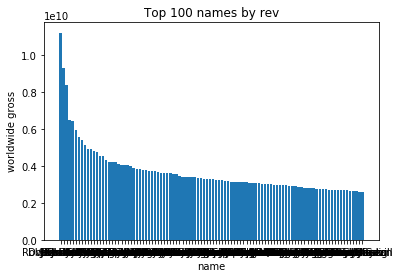

In [13]:
plt.bar(top_100_names['primary_name'],top_100_names['worldwide_gross'])
plt.title('Top 100 names by rev')
plt.xlabel('name')
plt.ylabel('worldwide gross')
plt.show()
#see gian step down at ~6*10^9

In [10]:
top_5_names = df_names_rev_grouped.nlargest(5,'worldwide_gross')
top_5_names
#keep everything above 6*10^9

,nconst,primary_name,primary_profession,worldwide_gross
0,nm0498278,Stan Lee,"producer,writer,actor",1.118786e+10
1,nm0456158,Jack Kirby,"writer,animation_department,miscellaneous",9.285562e+09
2,nm0000375,Robert Downey Jr.,"actor,producer,soundtrack",8.361736e+09
3,nm0425005,Dwayne Johnson,"actor,producer,soundtrack",6.470420e+09
4,nm0270559,Kevin Feige,"producer,miscellaneous,production_manager",6.441697e+09


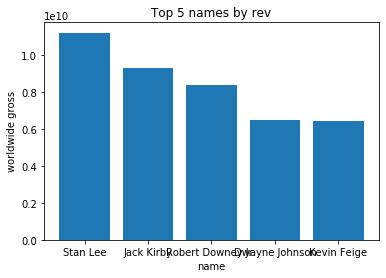

In [14]:
plt.bar(top_5_names['primary_name'],top_5_names['worldwide_gross'])
plt.title('Top 5 names by rev')
plt.xlabel('name')
plt.ylabel('worldwide gross')
plt.show()